# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [6]:
!pip install -qU ragas==0.2.10

In [ ]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

In [1]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [2]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [3]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [4]:
!mkdir data

In [5]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31427    0 31427    0     0   8377      0 --:--:--  0:00:03 --:--:--  8376


In [6]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70286    0 70286    0     0  19997      0 --:--:--  0:00:03 --:--:-- 19996


Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [4]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

[nltk_data] Downloading package punkt to /home/ngiometti/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ngiometti/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [5]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

/home/ngiometti/aie5/code/aie5/07_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/pysbd/segmenter.py:66: SyntaxWarning: invalid escape sequence '\s'
  for match in re.finditer('{0}\s*'.format(re.escape(sent)), self.original_text):
/home/ngiometti/aie5/code/aie5/07_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/pysbd/lang/arabic.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)
/home/ngiometti/aie5/code/aie5/07_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/pysbd/lang/persian.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)


Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [6]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [7]:
from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 2, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [8]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 14, relationships: 62)

We can save and load our knowledge graphs as follows.

In [9]:
kg.save("ai_across_years_kg.json")
ai_across_years_kg = KnowledgeGraph.load("ai_across_years_kg.json")
ai_across_years_kg

KnowledgeGraph(nodes: 14, relationships: 62)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [10]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=ai_across_years_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [11]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.


### Nick's Answer to Question #1:

SingleHopSpecificQuerySynthesizer: generates a query that would require a specific answer from a single document.

MultiHopAbstractQuerySynthesizer: generates a query that would require answeringa more abstract question that doesn't have an exact match and would be more conceptual, also requiring searching multiple documents.

MultiHopSpecificQuerySynthesize: generates a query that requires a specific answer but requires searching multiple documents.

Finally, we can use our `TestSetGenerator` to generate our testset!

In [12]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,What advancements have been made with Claude 3...,[Prompt driven app generation is a commodity a...,"Claude 3.5 Sonnet, launched in June, became a ...",single_hop_specifc_query_synthesizer
1,Wht is Anthropic's cheapest model?,"[gets you OpenAI’s most expensive model, o1. G...","Anthropic’s cheapest model is Claude 3 Haiku, ...",single_hop_specifc_query_synthesizer
2,Could you elaborate on the significance of Cla...,[your camera feed with the model and talk abou...,Claude Artifacts is a groundbreaking feature r...,single_hop_specifc_query_synthesizer
3,How has OpenAI contributed to the advancements...,[“agents” as dependent on AGI itself. A model ...,OpenAI has contributed to the advancements in ...,single_hop_specifc_query_synthesizer
4,Meta big in AI?,[day after that. DeepSeek v3 is a huge 685B pa...,Meta is involved in the competitive buildout o...,single_hop_specifc_query_synthesizer
5,How have inference-scaling reasoning models an...,[<1-hop>\n\nPrompt driven app generation is a ...,Inference-scaling reasoning models and automat...,multi_hop_abstract_query_synthesizer
6,How have inference-scaling reasoning models an...,[<1-hop>\n\nPrompt driven app generation is a ...,"Inference-scaling reasoning models, such as Op...",multi_hop_abstract_query_synthesizer
7,How do inference-scaling reasoning models and ...,[<1-hop>\n\nPrompt driven app generation is a ...,"Inference-scaling reasoning models, such as Op...",multi_hop_abstract_query_synthesizer
8,How has Anthropic contributed to the advanceme...,[<1-hop>\n\nCode may be the best application T...,Anthropic has been a significant contributor t...,multi_hop_specific_query_synthesizer
9,What role did Claude play in the development o...,[<1-hop>\n\nneeds guidance. Those of us who un...,"In 2024, Claude was involved in various projec...",multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [13]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [14]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What advancements and features make Claude 3.5...,[Prompt driven app generation is a commodity a...,"Claude 3.5 Sonnet, launched by Anthropic in Ju...",single_hop_specifc_query_synthesizer
1,What are the cost advantages of using GPT-4o c...,"[gets you OpenAI’s most expensive model, o1. G...",GPT-4o is significantly cheaper than previous ...,single_hop_specifc_query_synthesizer
2,What recent advancements have been made in Cha...,[your camera feed with the model and talk abou...,OpenAI started with a WebSocket API that was q...,single_hop_specifc_query_synthesizer
3,Who is Malte Ubl and what was his approach to ...,[“agents” as dependent on AGI itself. A model ...,"Malte Ubl is associated with Vercel, and his a...",single_hop_specifc_query_synthesizer
4,How have the training costs and environmental ...,[<1-hop>\n\nCode may be the best application T...,The training costs for large language models (...,multi_hop_abstract_query_synthesizer
5,What are the ethical implications of using unl...,[<1-hop>\n\nCode may be the best application T...,The ethical implications of using unlicensed t...,multi_hop_abstract_query_synthesizer
6,What are the ethical concerns related to the t...,[<1-hop>\n\nCode may be the best application T...,The ethical concerns related to the training d...,multi_hop_abstract_query_synthesizer
7,Considering the ethical implications of traini...,[<1-hop>\n\nCode may be the best application T...,The use of unlicensed data in the development ...,multi_hop_abstract_query_synthesizer
8,What are the ethical implications of using Cha...,[<1-hop>\n\nyour camera feed with the model an...,The ethical implications of using ChatGPT for ...,multi_hop_specific_query_synthesizer
9,"How does the efficiency and pricing of LLMs, l...",[<1-hop>\n\nreasoning patterns. Another common...,"The efficiency and pricing of LLMs, such as Me...",multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [15]:
from langsmith import Client

client = Client()

dataset_name = "State of AI Across the Years!"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="State of AI Across the Years!"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [16]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [17]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [18]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [19]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [20]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="State of AI"
)

In [21]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [22]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [23]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Finally, we can set-up our RAG LCEL chain!

In [24]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [25]:
rag_chain.invoke({"question" : "What are Agents?"})

'The term "agents" refers to AI systems that are designed to act on your behalf, similar to the role of a travel agent or as LLMs that utilize tools in a loop for problem-solving. However, the term is considered vague and lacks a clear, widely understood definition, leading to frustration in discussions about it. There are various interpretations of what "agents" can be, and the concept is often associated with the challenge of gullibility, as these systems need to make meaningful decisions and distinguish truth from fiction.'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4o as our evaluation LLM for our base Evaluators.

In [26]:
eval_llm = ChatOpenAI(model="gpt-4o")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [27]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`:
- `labeled_helpfulness_evaluator`:
- `dope_or_nope_evaluator`:

### Nick's Answer to Activity #2:

- the qa_evaluator is evaluating the accuracy or "correctness" of the answer generated from the RAG system compared to the reference answer from the test dataset using the original question.
- the labeled_helpfulness_evaluator is evaluating the helpfulness of the answer generated from the RAG system compared to the reference answer from the test dataset using the original question.
- the dope_or_nope_evaluator is evaluating the coolness of the answer generated from the RAG system compared to the reference answer from the test dataset using the original question.

## LangSmith Evaluation

In [28]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'crushing-vegetable-87' at:
https://smith.langchain.com/o/2594f37c-5713-437b-b601-2c8371b803bd/datasets/dd73ec73-b68c-4b60-834d-cce6e965088d/compare?selectedSessions=b007c1dd-b2d6-46e9-88b5-c11323cf18a9




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How does Meta's approach to synthetic data in ...,I don't know.,None,Meta's approach to synthetic data in LLM train...,0,0,0,0.742367,f53b0f57-bfc6-482e-b824-3a9d3190df03,00dbcc38-7f11-4b68-8aac-2c3c7b9cb2ae
1,How did the Claude 3 series contribute to the ...,"The Claude 3 series, launched by Anthropic in ...",None,"The Claude 3 series, launched by Anthropic in ...",1,0,1,4.166680,bcdb0c3b-afb4-447d-a9e5-b8d327039e0c,959ff565-45f9-4157-b906-526b2961e56c
2,"How does the efficiency and pricing of LLMs, l...","The efficiency of LLMs, such as Meta's Llama a...",None,"The efficiency and pricing of LLMs, such as Me...",1,1,0,2.597304,404eeccd-55bc-4a74-b7db-7bf07e7eac5b,55b0afdd-2391-4dcf-bc2d-22cef23b8dfb
3,What are the ethical implications of using Cha...,I don't know.,None,The ethical implications of using ChatGPT for ...,0,0,0,1.242407,868c05fb-aa91-46ec-b65b-8e8318480c75,77b551b9-f0f8-4188-80b9-113d50abdcc7
4,Considering the ethical implications of traini...,I don't know.,None,The use of unlicensed data in the development ...,0,0,0,0.683945,3589509c-8838-4ac0-aeba-05a8be0556b8,de942b3e-2536-4f14-8cfe-6f02c4213b90
5,What are the ethical concerns related to the t...,The ethical concerns related to the training d...,None,The ethical concerns related to the training d...,1,0,0,4.503732,e5c9944c-93de-498f-a153-662077109fc1,fc8125d4-024d-4ba2-a986-ccd3174206df
6,What are the ethical implications of using unl...,The ethical implications of using unlicensed t...,None,The ethical implications of using unlicensed t...,1,0,0,2.830728,b9fa9f08-42d8-4581-919c-40f9b93eea07,db2111d8-9a21-4fcd-8f91-6b14eabce6ee
7,How have the training costs and environmental ...,"The training costs for AI models, specifically...",None,The training costs for large language models (...,1,0,0,2.827779,02fcfda4-0ed1-4e50-b0df-415bb1f02f84,ee1f541a-444a-45fe-995c-7a75e7ccef15
8,Who is Malte Ubl and what was his approach to ...,"Malte Ubl is from Vercel, and his approach to ...",None,"Malte Ubl is associated with Vercel, and his a...",0,0,0,1.441189,2969fd07-b7d3-41eb-af80-10087027879e,6112a977-f949-48e5-9deb-3d54d1957c75
9,What recent advancements have been made in Cha...,"OpenAI announced a new WebRTC API in December,...",None,OpenAI started with a WebSocket API that was q...,1,1,1,1.516012,5da11e9d-b43a-4c14-8187-4b1ee30af158,181d94b0-151f-4545-91d4-7d244f16cecd


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [29]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool!

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [30]:
rag_documents = docs

In [31]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

### Nick's Answer to Question #2:

Modifying the chunk size can modify the performance of our application because it can affect the quality of the context that is provided to the LLM. If the chunk size is too small, the LLM may not have enough context to generate a good answer, and if the chunk size is too large, the LLM may not be able to handle the context.


In [32]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

### Nick's Answer to Question #3:

Modifying the embedding model can modify the performance of our application because it can affect the quality of the context that is provided to the LLM. If the embedding model has too few dimensions, the LLM may not be able to understand the context properly given the question and its domain. Fine-tuning embedding models or increasing the number of dimensions can improve the performance of the application, particularly for jargon-heavy domains.

In [33]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Across Years (Augmented)"
)

In [34]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [35]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [36]:
dope_rag_chain.invoke({"question" : "what are Agents?"})

"Agents are like these elusive AI systems that are supposed to act on your behalf—think travel agents or digital assistants. But here's the kicker: the term “agents” is super vague and feels like it’s still in the testing phase. People have different definitions, and the utility of agents is under fire, especially when it comes to their ability to discern truth from fiction. It's like waiting for a mythical creature to show up—exciting but kind of frustrating!"

Finally, we can evaluate the new chain on the same test set!

In [37]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

View the evaluation results for experiment: 'large-sponge-68' at:
https://smith.langchain.com/o/2594f37c-5713-437b-b601-2c8371b803bd/datasets/dd73ec73-b68c-4b60-834d-cce6e965088d/compare?selectedSessions=005b888a-366d-407e-8388-a2b520e8947a




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How does Meta's approach to synthetic data in ...,"Yo, that’s an interesting mashup! Meta's appro...",None,Meta's approach to synthetic data in LLM train...,1,0,1,2.611191,f53b0f57-bfc6-482e-b824-3a9d3190df03,46faba79-1113-4098-8942-19ae214f36fe
1,How did the Claude 3 series contribute to the ...,"Yo, the Claude 3 series really stepped up the ...",None,"The Claude 3 series, launched by Anthropic in ...",1,0,1,4.025219,bcdb0c3b-afb4-447d-a9e5-b8d327039e0c,5e4076b3-6d06-4ae2-9d40-25788ec17220
2,"How does the efficiency and pricing of LLMs, l...","Yo, check it out! The efficiency and pricing o...",None,"The efficiency and pricing of LLMs, such as Me...",1,0,1,5.978280,404eeccd-55bc-4a74-b7db-7bf07e7eac5b,b87606c8-5954-4f33-830a-052831f485c0
3,What are the ethical implications of using Cha...,"Yo, when it comes to the ethical implications ...",None,The ethical implications of using ChatGPT for ...,1,1,1,4.769818,868c05fb-aa91-46ec-b65b-8e8318480c75,5fa8c244-ca75-4e62-a1d7-3804633965af
4,Considering the ethical implications of traini...,The ethical implications of using unlicensed d...,None,The use of unlicensed data in the development ...,1,0,1,2.878922,3589509c-8838-4ac0-aeba-05a8be0556b8,8120c55e-86c9-472a-8872-448d04a9553f
5,What are the ethical concerns related to the t...,"Yo, let’s break it down! The ethical concerns ...",None,The ethical concerns related to the training d...,1,1,1,2.846238,e5c9944c-93de-498f-a153-662077109fc1,d5a746fc-2056-4f1e-945b-65465ec250a5
6,What are the ethical implications of using unl...,The ethical implications of using unlicensed t...,None,The ethical implications of using unlicensed t...,1,1,1,4.454361,b9fa9f08-42d8-4581-919c-40f9b93eea07,e4d88699-cba9-42fa-a023-e5e81111abd6
7,How have the training costs and environmental ...,Yo! So here's the lowdown on training costs an...,None,The training costs for large language models (...,1,1,1,3.985605,02fcfda4-0ed1-4e50-b0df-415bb1f02f84,264e9d41-8c0b-4c18-a72f-0a75a12a9a01
8,Who is Malte Ubl and what was his approach to ...,"Malte Ubl is a key player at Vercel, and when ...",None,"Malte Ubl is associated with Vercel, and his a...",1,1,1,2.716612,2969fd07-b7d3-41eb-af80-10087027879e,52dcf1ac-034b-45d4-ba5f-aa6e3ab45418
9,What recent advancements have been made in Cha...,"Yo, check it out! Recently, OpenAI dropped a n...",None,OpenAI started with a WebSocket API that was q...,1,1,1,1.903929,5da11e9d-b43a-4c14-8187-4b1ee30af158,4a46a84d-1583-4e1a-8ee3-5493ead0c0d0


#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

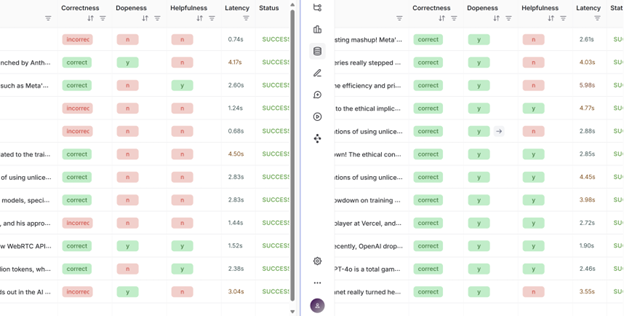

In [39]:
from IPython.display import Image

Image(filename='Langsmith_screenshot.png')


### Nick's Answer to Activity #3:

The first screenshot shows the original RAG chain, which is not very good at generating dope answers. The second screenshot shows the DOPE RAG chain, which is much better at generating dope answers.

The dopeness metrics increased across the board, which indicates that the DOPE RAG chain is better at generating dope answers.

Improvement across the board for correctness and helpfulness could be from using a better embedding model and a larger chunk size with overlapping chunks.